<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_CNN_MPIE_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
path_root = '/content/drive/MyDrive/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!pwd

/content/drive/MyDrive/Colab Notebooks/00.study/10.knou/datas


##Load Trained Model

In [2]:
import pickle
results_file = 'results_CNN_202205290150.pickle'
with open(results_file, 'rb') as f:
  results = pickle.load(f)
results   # model, history, execution_time, _params

[(<keras.engine.sequential.Sequential at 0x7f260c815e90>,
  82.97611904144287,
  {'_activation': 'sigmoid',
   '_class_cnt': 5,
   '_kernel_initializer': None,
   '_kernel_size': (3, 3),
   '_optimizer': 'Adam',
   '_padding': 'same',
   '_strides': (1, 1),
   'batch_normal': False,
   'epochs': 50,
   'filters': 16,
   'label_class': 4,
   'pool_type': 'average'}),
 (<keras.engine.sequential.Sequential at 0x7f2601329c10>,
  80.95225310325623,
  {'_activation': 'sigmoid',
   '_class_cnt': 5,
   '_kernel_initializer': None,
   '_kernel_size': (3, 3),
   '_optimizer': 'Adam',
   '_padding': 'same',
   '_strides': (1, 1),
   'batch_normal': False,
   'epochs': 50,
   'filters': 16,
   'label_class': 4,
   'pool_type': 'max'}),
 (<keras.engine.sequential.Sequential at 0x7f2601329790>,
  83.16095161437988,
  {'_activation': 'sigmoid',
   '_class_cnt': 5,
   '_kernel_initializer': None,
   '_kernel_size': (3, 3),
   '_optimizer': 'Adam',
   '_padding': 'same',
   '_strides': (1, 1),
   'batc

## show model

In [3]:
def drawModel(index, model, savefile=True):
  tf.keras.utils.plot_model(model, to_file=f'model_{index}.png', show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True, ) #layer_range=?, 

model = results[0][0]
# drawModel(None, model)
print(len(model.layers), model.layers, )

7 [<keras.layers.convolutional.Conv2D object at 0x7f26081c2ed0>, <keras.layers.core.activation.Activation object at 0x7f2605265fd0>, <keras.layers.pooling.AveragePooling2D object at 0x7f26015084d0>, <keras.layers.core.flatten.Flatten object at 0x7f260150b110>, <keras.layers.core.dense.Dense object at 0x7f2605265dd0>, <keras.layers.core.dropout.Dropout object at 0x7f2601511650>, <keras.layers.core.dense.Dense object at 0x7f2601511fd0>]


##drawing history model

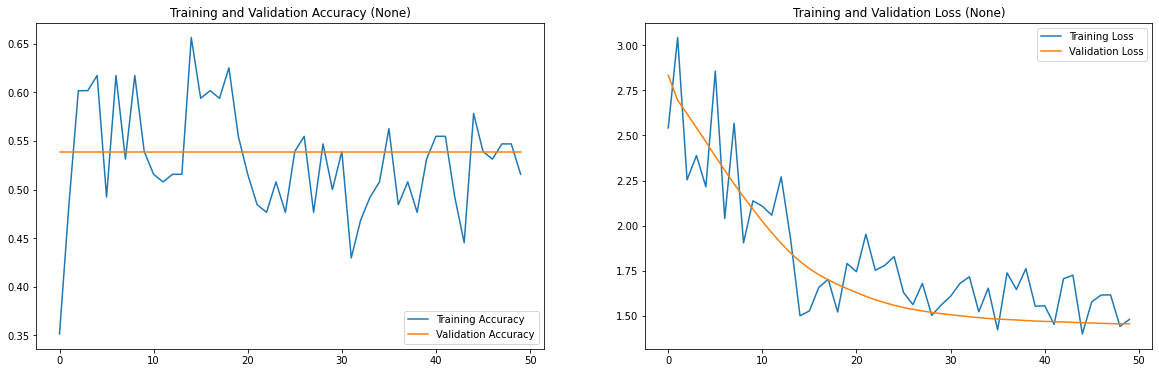

In [4]:
import matplotlib.pyplot as plt

def drawModelHistory(index, history, training_time, filesave=True):
  _epochs = history.params['epochs']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(_epochs)
  # acc, list(epochs_range)

  plt.figure(figsize=(20, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title(f'Training and Validation Accuracy ({index})')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title(f'Training and Validation Loss ({index})')
  plt.savefig(f'history_{index}.png', bbox_inches='tight')
  plt.show()

history = results[0][1]
drawModelHistory(None, history, None)

##make list from anothers params

In [5]:
training_time = results[0][2]
params = results[0][3]

In [6]:
history.history.keys(), history.params.keys(), training_time, params.keys()

(dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']),
 dict_keys(['verbose', 'epochs', 'steps']),
 82.97611904144287,
 dict_keys(['filters', '_padding', '_kernel_initializer', '_activation', '_optimizer', 'batch_normal', 'epochs', '_kernel_size', '_strides', 'pool_type', '_class_cnt', 'label_class']))

In [7]:
# list(history.history.values())[0], type(history.history.values()), 

In [8]:
import numpy as np

history_values = np.array(list(history.history.values()))
history_values.shape, history_values[:,-1], list(history_values[:,-1])


((4, 50),
 array([1.47884321, 0.515625  , 1.45456147, 0.53873378]),
 [1.4788432121276855, 0.515625, 1.454561471939087, 0.5387337803840637])

In [9]:
history_values = list(np.array(list(history.history.values()))[:,-1])
history_values

[1.4788432121276855, 0.515625, 1.454561471939087, 0.5387337803840637]

In [10]:
list(history.params.values())

[1, 50, 2]

In [11]:
params_values = list(params.values())
# params_values

In [12]:
_training_time = [training_time]
_training_time, type(_training_time)

([82.97611904144287], list)

In [13]:
import numpy as np
# value list : params + history values + model layers + training time + history params
def resultvaluesTolist(model, history, training_time, params):
  model_layer_depth = [len(model.layers)]
  history_values = list(np.array(list(history.history.values()))[:,-1])
  history_params = list(history.params.values())
  _training_time = [training_time]
  params_values = list(params.values())
  _value_list = params_values + history_values + model_layer_depth + _training_time + history_params
  return _value_list
value_list = resultvaluesTolist(model, history, training_time, params)
# value_list

## store results

In [14]:
import tensorflow as tf
result_list = list()
for idx, result in enumerate(results):
  model, history, training_time, params = result[0], result[1], result[2], result[3]
  print(f'Training Time : {training_time:.3f} sec')
  # drawModelHistory(idx, history, training_time)
  result_list.append(resultvaluesTolist(model, history, training_time, params))


Training Time : 82.976 sec
Training Time : 80.952 sec
Training Time : 83.161 sec
Training Time : 79.547 sec
Training Time : 83.880 sec
Training Time : 80.724 sec


##evaluation with params value

In [15]:
column_name = list(params.keys())+list(history.history.keys())+['model_layer_depth','training_time']+list(history.params.keys())
print(column_name, len(column_name))

['filters', '_padding', '_kernel_initializer', '_activation', '_optimizer', 'batch_normal', 'epochs', '_kernel_size', '_strides', 'pool_type', '_class_cnt', 'label_class', 'loss', 'accuracy', 'val_loss', 'val_accuracy', 'model_layer_depth', 'training_time', 'verbose', 'epochs', 'steps'] 21


In [16]:
import pandas as pd
result_df = pd.DataFrame(data=result_list, columns=column_name)
# result_df_epochs
result_df_epochs = result_df.iloc[:,[6]]

result_df.drop(labels='epochs', axis=1, inplace=True)
result_df = pd.concat([result_df, result_df_epochs], axis=1)
result_df.keys()
result_df

,filters,_padding,_kernel_initializer,_activation,_optimizer,batch_normal,_kernel_size,_strides,pool_type,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,verbose,steps,epochs
0,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.478843,0.515625,1.454561,0.538734,7,82.976119,1,2,50
1,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.402791,0.570312,1.450625,0.538734,7,80.952253,1,2,50
2,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.918592,0.171875,1.602529,0.231420,7,83.160952,1,2,50
3,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.745440,0.218750,1.603073,0.231420,7,79.546945,1,2,50
4,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.670495,0.289062,1.473867,0.328746,7,83.880281,1,2,50
5,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.638149,0.281250,1.471895,0.328746,7,80.724359,1,2,50


In [17]:
result_columns = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

# result_df_useful = result_df.loc[:,'filters':'training_time']
result_df_useful = result_df.sort_values(result_columns, ascending = [True, False, True, False])

result_df_useful

,filters,_padding,_kernel_initializer,_activation,_optimizer,batch_normal,_kernel_size,_strides,pool_type,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,verbose,steps,epochs
1,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.402791,0.570312,1.450625,0.538734,7,80.952253,1,2,50
0,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.478843,0.515625,1.454561,0.538734,7,82.976119,1,2,50
5,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.638149,0.281250,1.471895,0.328746,7,80.724359,1,2,50
4,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.670495,0.289062,1.473867,0.328746,7,83.880281,1,2,50
3,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.745440,0.218750,1.603073,0.231420,7,79.546945,1,2,50
2,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.918592,0.171875,1.602529,0.231420,7,83.160952,1,2,50


###Ascending Rank with low loss and high accuracy
기준 : low loss and high accuracy (Overfitting은 다른 모델 방식에서 고려)

In [18]:
result_rank = 6

In [19]:
result_df_rank = result_df_useful.iloc[:result_rank]
result_df_rank

,filters,_padding,_kernel_initializer,_activation,_optimizer,batch_normal,_kernel_size,_strides,pool_type,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,verbose,steps,epochs
1,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.402791,0.570312,1.450625,0.538734,7,80.952253,1,2,50
0,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.478843,0.515625,1.454561,0.538734,7,82.976119,1,2,50
5,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.638149,0.281250,1.471895,0.328746,7,80.724359,1,2,50
4,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.670495,0.289062,1.473867,0.328746,7,83.880281,1,2,50
3,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.745440,0.218750,1.603073,0.231420,7,79.546945,1,2,50
2,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.918592,0.171875,1.602529,0.231420,7,83.160952,1,2,50


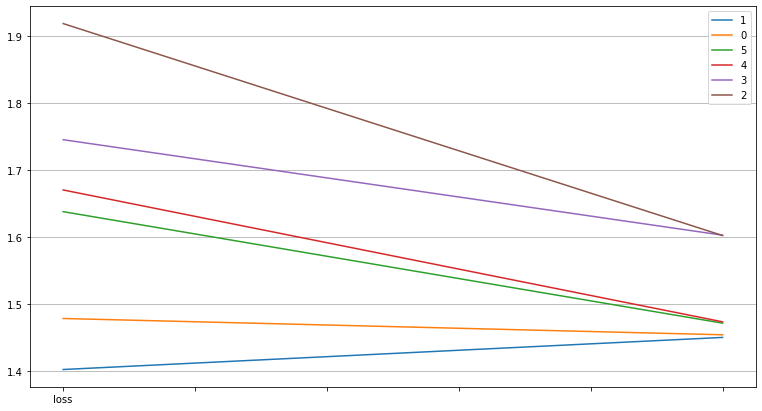

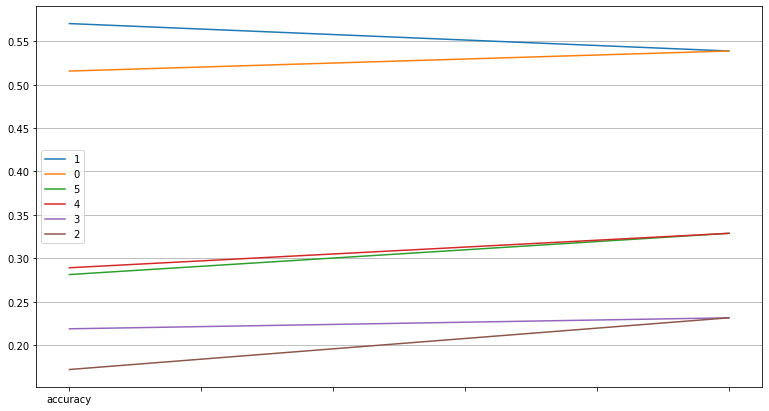

In [42]:
# result_df_rank[result_columns]
plt.rcParams["figure.figsize"] = (13, 7)
result_df_rank[['loss', 'val_loss']].T.plot()
plt.grid(axis='y')
# plt.xticks(rotation=20)
plt.show()

result_df_rank[['accuracy', 'val_accuracy']].T.plot()
plt.grid(axis='y')
# plt.xticks(rotation=20)
plt.show()

In [21]:
result_df_rank_str = result_df_rank.astype('str')
result_df_rank_str.dtypes
result_df_rank_str

,filters,_padding,_kernel_initializer,_activation,_optimizer,batch_normal,_kernel_size,_strides,pool_type,_class_cnt,label_class,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time,verbose,steps,epochs
1,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.4027912616729736,0.5703125,1.4506250619888306,0.5387337803840637,7,80.95225310325623,1,2,50
0,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.4788432121276855,0.515625,1.454561471939087,0.5387337803840637,7,82.97611904144287,1,2,50
5,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.6381494998931885,0.28125,1.471895456314087,0.328745573759079,7,80.72435855865479,1,2,50
4,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.670494794845581,0.2890625,1.473867416381836,0.328745573759079,7,83.88028144836426,1,2,50
3,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,1.7454395294189453,0.21875,1.6030725240707397,0.23141957819461823,7,79.54694485664368,1,2,50
2,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,1.9185922145843506,0.171875,1.6025285720825195,0.23141957819461823,7,83.16095161437988,1,2,50


In [22]:
columns_mask_str = result_df_rank_str.columns.map(lambda x: True if (x not in ('loss','accuracy','val_loss','val_accuracy','verbose','training_time','steps')) else False )
columns_mask_str, len(list(columns_mask_str))

(Index([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False,  True, False, False, False,  True],
       dtype='object'), 20)

In [23]:
result_df_rank_str_pick = result_df_rank_str.loc[:,columns_mask_str].value_counts().reset_index()
type(result_df_rank_str_pick), 
result_df_rank_str_pick.drop(labels=0, axis=1, inplace=True)
result_df_rank_str_pick

,filters,_padding,_kernel_initializer,_activation,_optimizer,batch_normal,_kernel_size,_strides,pool_type,_class_cnt,label_class,model_layer_depth,epochs
0,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",average,5,4,7,50
1,16,same,None,sigmoid,Adam,False,"(3, 3)","(1, 1)",max,5,4,7,50


##학습 결과 영향 params 확인

In [24]:
len(result_df_rank_str_pick['filters'].unique()), result_df_rank_str_pick['pool_type'].unique(), len(result_df_rank_str_pick['pool_type'].unique())


(1, array(['average', 'max'], dtype=object), 2)

In [26]:
result_measure_columns = list()
for column in result_df_rank_str_pick.columns:
  if len(result_df_rank_str_pick[column].unique()) > 1:
    result_measure_columns.append(column)
result_measure_columns

['pool_type']

In [31]:
result_columns = result_columns + result_measure_columns
result_df_rank_params = result_df_rank[result_columns]
result_df_rank_params

In [33]:
file_name = 'Term_2_CNN_MPIE_results.csv'
result_df_rank_params.to_csv(file_name)